### Building Logistic Regression Using a Neural Net

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Data Generation

The main goal of the notebook is to practice building a neural network. In our case, we have to implement a logistic regression model using a simple neuron.

Create a simple binary classification task where classes only slightly overlap each other.

In [347]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=5000, centers=2, n_features=10, random_state=42, cluster_std=4)

Visualize the data in 2D using PCA

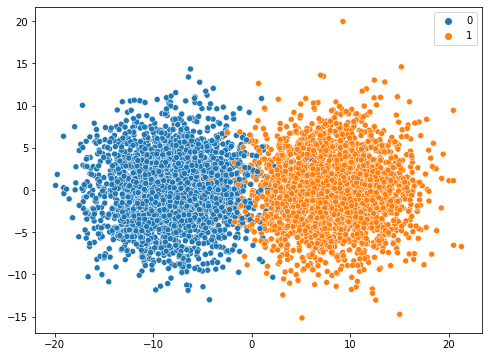

In [348]:
dim_red_method = PCA(n_components=2)
x_red_dim = dim_red_method.fit_transform(x)

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x_red_dim[:,0], x_red_dim[:,1], hue=y);

### Data Preparation
Classes are balanced, thus no need to apply stratification. Only conduct `train_test_split`

In [349]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

print('Shape x_train: ', x_train.shape)
print('Shape y_train: ', y_train.shape)
print('Shape x_test: ', x_test.shape)
print('Shape y_test: ', y_test.shape)

Shape x_train:  (4000, 10)
Shape y_train:  (4000,)
Shape x_test:  (1000, 10)
Shape y_test:  (1000,)


let's scale the features

In [350]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

For vectorized implementation we have to change shapes of train and test vectors

In [351]:
x_train = x_train.T # (n_features x n_samples)
y_train = y_train[np.newaxis, :] # row-vector

x_test = x_test.T 
y_test = y_test[np.newaxis, :]

print('Shape x_train: ', x_train.shape)
print('Shape y_train: ', y_train.shape)
print('Shape x_test: ', x_test.shape)
print('Shape y_test: ', y_test.shape)

Shape x_train:  (10, 4000)
Shape y_train:  (1, 4000)
Shape x_test:  (10, 1000)
Shape y_test:  (1, 1000)


### Logistic Regression Implementation

**Mathematical expression of the algorithm**:

**Forward Propagation** for one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

**The cost** is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Back Propagation**

Have to calculate the gradients 
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$



### Helper Functions
For easier model implementation let's define some functions that will do some steps:
- `sigmoid()`
- `init_params()`
- `propagate_forward()`
- `calculate_cost()`
- `propagate_back()`
- `optimize()`
- `predict()`

In [352]:
# Sigmoid Function 
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

# Neuron Parameters Intialization 
def init_params(x_in_shape):
    W = np.random.randn(x_in_shape[0], 1)*0.01
    B = 0.0
    
    return W, B 

# Forward Prop
def propagate_forward(X, W, B):
    Z = np.dot(W.T, X) + B
    A = sigmoid(Z)
    
    return A
    
# Cost Function (elementwise product)
def calculate_cost(Y_hat, Y):
    """Y_hat ~ A[L]"""
    m = Y_hat.shape[1]
    
    return -1/m * np.sum(((Y*np.log(Y_hat)) + (1 - Y)*np.log(1 - Y_hat)), axis=1, keepdims=True)

# Back Prop
def propagate_back(X, A, Y):
    m = X.shape[1]
    dW = 1/m * np.dot(X, (A - Y).T)
    dB = 1/m * np.sum((A - Y), axis=1, keepdims=True)
    
    grads = {'dW': dW, 'dB': dB}
    
    return grads

def optimize(W, B, X, Y, num_iterations=100, learning_rate=0.009, return_cost=True, show_iter_cost=False):
    costs = []
    for cur_iter in range(num_iterations):
        A = propagate_forward(X=X, W=W, B=B)
        cost = calculate_cost(Y_hat=A, Y=Y)
        cur_grads = propagate_back(X=X, A=A, Y=Y)
        
        costs.append(cost)
        
        # Retrieve Current Gradients 
        dW = cur_grads['dW']
        dB = cur_grads['dB']
        
        # Update Parameters (Gradient Descent)
        W = W - learning_rate*dW
        B = B - learning_rate*dB
        
        if show_iter_cost:
            if cur_iter % 100 == 0:
                print(f'Iteration: {cur_iter} Cost: {cost}')
            
    opt_params = {'W': W, 'B': B}
    final_grads = {'dW': dW, 'dB': dB}
    
    if return_cost:
        return opt_params, final_grads, costs
    
    else:
        return opt_params, final_grads

def predict(opt_W, opt_B, X):
    A = propagate_forward(X=X, W=opt_W, B=opt_B)
    return np.where(A > 0.5, 1, 0)

In [353]:
def model(X_train, Y_train, X_test, Y_test, 
          num_iterations=300, learning_rate=0.5, show_accuracy=True, return_params=True, show_iter_cost=False):
    W, B = init_params(x_in_shape=X_train.shape)
    opt_params, final_grads, costs = optimize(W, B, X=X_train, Y=Y_train, num_iterations=num_iterations,
                                              learning_rate=0.009, return_cost=True, show_iter_cost=show_iter_cost)
    
    Y_prediction_train = predict(opt_W=opt_params['W'], opt_B=opt_params['B'], X=X_train)
    Y_prediction_test = predict(opt_W=opt_params['W'], opt_B=opt_params['B'], X=X_test)
    
    if show_accuracy:
        print('Train Accuracy: ', 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100)
        print('Test Accuracy: ', 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100)
        
    if return_params:
        return opt_params, final_grads, costs

In [354]:
params, grads, costs = model(X_train=x_train,
                             Y_train=y_train,
                             X_test=x_test,
                             Y_test=y_test,
                             num_iterations=250,
                             learning_rate=0.5, show_accuracy=True, return_params=True, show_iter_cost=True)

Iteration: 0 Cost: [[0.68792406]]
Iteration: 100 Cost: [[0.38635133]]
Iteration: 200 Cost: [[0.27825239]]
Train Accuracy:  98.15
Test Accuracy:  98.7


Not bad, we achieved 98.7 Accuracy on Test Data

### Trying Different Learning Rates
The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates

Train Accuracy:  98.25
Test Accuracy:  98.7
Train Accuracy:  98.275
Test Accuracy:  98.7
Train Accuracy:  98.275
Test Accuracy:  98.6


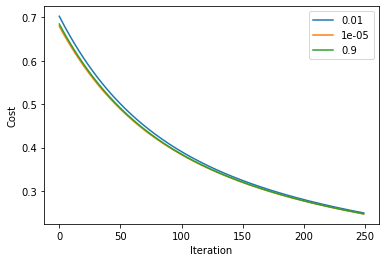

In [367]:
learning_rates = [1e-2, 1e-5, 0.9]

for l_rate in learning_rates:
    results = model(X_train=x_train, Y_train=y_train, X_test=x_test,
                    Y_test=y_test, num_iterations=250, learning_rate=0.5,
                    show_accuracy=True, return_params=True, show_iter_cost=False)
    plt.plot(np.squeeze(results[-1]), label=l_rate)
    
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend();

For this dataset it cannot be seen properly how learning rate affects the cost and convergence time (iteration)

But plotting such curves is worth a try!